## Testing Baseline ML Models witha big loop 

In [3]:
"""
ADHD Prediction Dataset - Baseline Models Evaluation

This notebook implements and evaluates baseline machine learning models for ADHD prediction
to establish performance benchmarks before advanced feature engineering and model optimization.

Author: [Your Name]
Date: [Date]
Project: ADHD Sex Prediction
Input: Baseline dataset (minimal preprocessing)
Output: Baseline model performance metrics and comparison
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import joblib

# =============================================================================
# CONFIGURATION AND SETTINGS
# =============================================================================

# Set random seed for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Plotting style
plt.style.use('default')
sns.set_palette("husl")


In [7]:
# =============================================================================
# DATA LOADING - USING PREPROCESSED SPLITS
# =============================================================================

def load_preprocessed_baseline_data():
    """
    Load preprocessed and balanced datasets for baseline model evaluation.
    
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test, X_val, y_val) - Preprocessed splits
    """
    print("LOADING PREPROCESSED DATASETS FOR BASELINE EVALUATION")
    print("=" * 60)
    
    try:
        # Load preprocessed splits
        X_train = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\X_train_balanced.pkl")
        y_train = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\y_train_balanced.pkl")
        X_val = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\X_val_processed.pkl")
        y_val = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\y_val.pkl")
        X_test = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\X_test_processed.pkl")
        y_test = joblib.load(r"C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\data\preprocessed data\y_test.pkl")

        print(f"   Datasets loaded successfully")
        print(f"   Training (balanced): {X_train.shape}")
        print(f"   Validation: {X_val.shape}")  
        print(f"   Test: {X_test.shape}")
        
        # Display target distributions
        print(f"\n Target Distributions:")
        train_dist = pd.Series(y_train).value_counts().sort_index()
        val_dist = pd.Series(y_val).value_counts().sort_index()
        test_dist = pd.Series(y_test).value_counts().sort_index()
        
        print(f"      Training: {dict(train_dist)} (balanced)")
        print(f"      Validation: {dict(val_dist)}")
        print(f"      Test: {dict(test_dist)}")
        
        # Convert to DataFrames if they're numpy arrays
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train)
            X_val = pd.DataFrame(X_val)
            X_test = pd.DataFrame(X_test)
        
        # Convert targets to Series if they're numpy arrays
        if not isinstance(y_train, pd.Series):
            y_train = pd.Series(y_train)
            y_val = pd.Series(y_val)
            y_test = pd.Series(y_test)
        
        print(f"\n   Data ready for baseline model evaluation")
        return X_train, X_test, y_train, y_test, X_val, y_val
        
    except FileNotFoundError as e:
        print(f"  Error: Preprocessed data files not found")
        print(f"   Make sure you've run the Data Preparation notebook first!")
        raise
    except Exception as e:
        print(f"  Error loading preprocessed data: {str(e)}")
        raise

# Load preprocessed data
X_train, X_test, y_train, y_test, X_val, y_val = load_preprocessed_baseline_data()

LOADING PREPROCESSED DATASETS FOR BASELINE EVALUATION
   Datasets loaded successfully
   Training (balanced): (815, 756)
   Validation: (200, 756)
   Test: (201, 756)

 Target Distributions:
      Training: {0: 408, 1: 407} (balanced)
      Validation: {0: 64, 1: 136}
      Test: {0: 64, 1: 137}

   Data ready for baseline model evaluation


 LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)      Performance Metrics:
          Accuracy: 0.7313
         Precision: 0.8487
         Recall: 0.7372
         F1-Binary: 0.7891
         F1-Macro: 0.7096
         F1-Weighted: 0.7385

  Confusion Matrix:


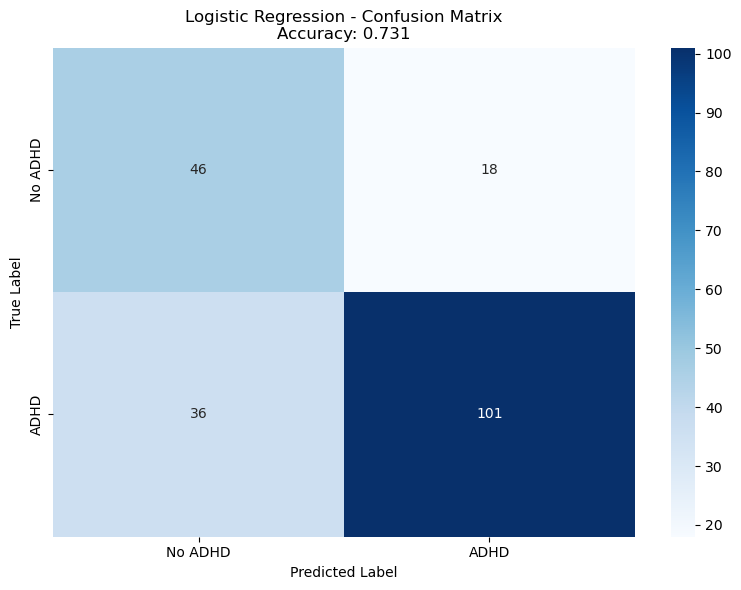

 RandomForestClassifier(class_weight='balanced', random_state=42)      Performance Metrics:
          Accuracy: 0.7512
         Precision: 0.7843
         Recall: 0.8759
         F1-Binary: 0.8276
         F1-Macro: 0.6906
         F1-Weighted: 0.7403

  Confusion Matrix:


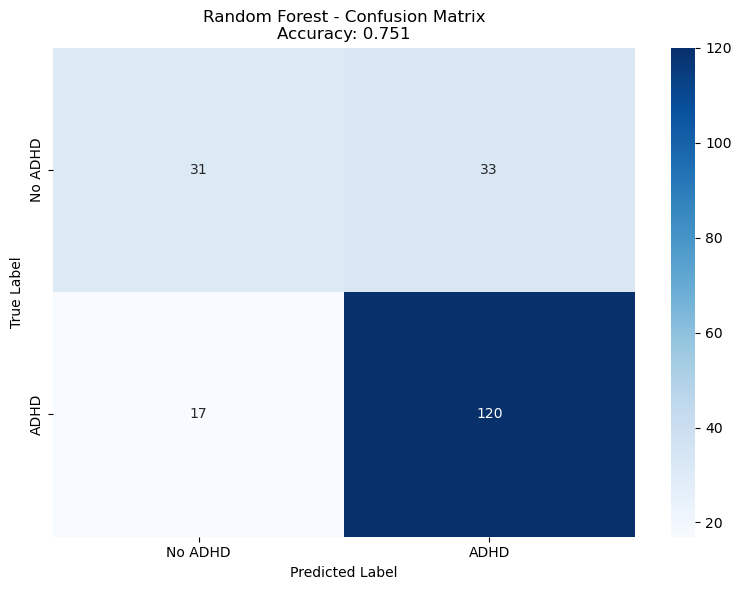

 SVC(class_weight='balanced', probability=True, random_state=42)      Performance Metrics:
          Accuracy: 0.6816
         Precision: 0.8017
         Recall: 0.7080
         F1-Binary: 0.7519
         F1-Macro: 0.6537
         F1-Weighted: 0.6894

  Confusion Matrix:


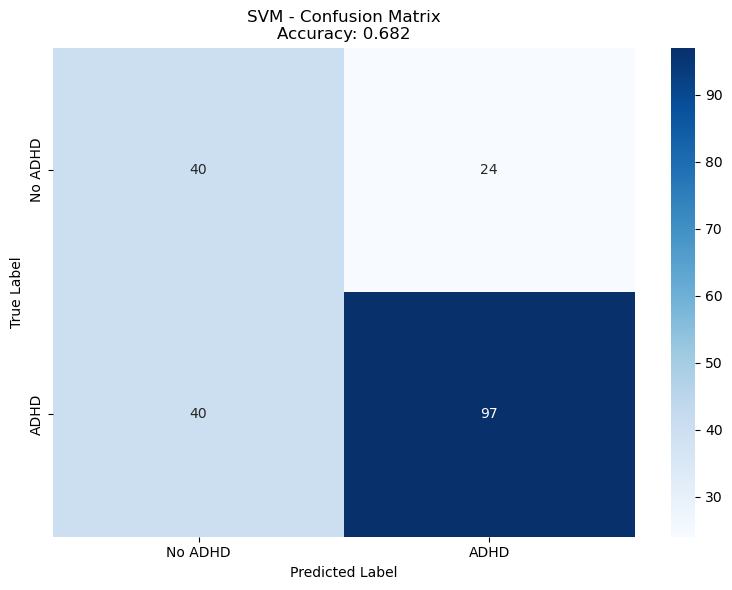

 LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)      Performance Metrics:
          Accuracy: 0.7711
         Precision: 0.8273
         Recall: 0.8394
         F1-Binary: 0.8333
         F1-Macro: 0.7341
         F1-Weighted: 0.7702

  Confusion Matrix:


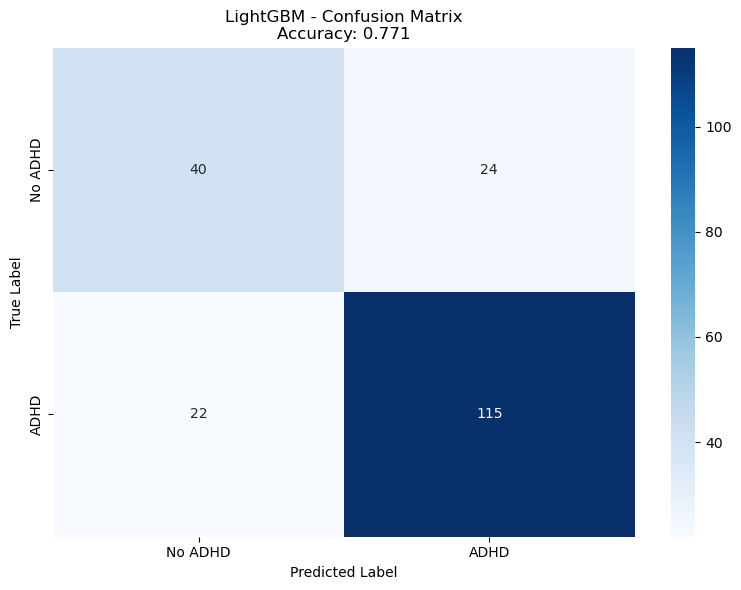

 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)      Performance Metrics:
          Accuracy: 0.7861
         Precision: 0.8310
         Recall: 0.8613
         F1-Binary: 0.8459
         F1-Macro: 0.7481
         F1-Weighted: 0.7836

  Confusion Matrix:


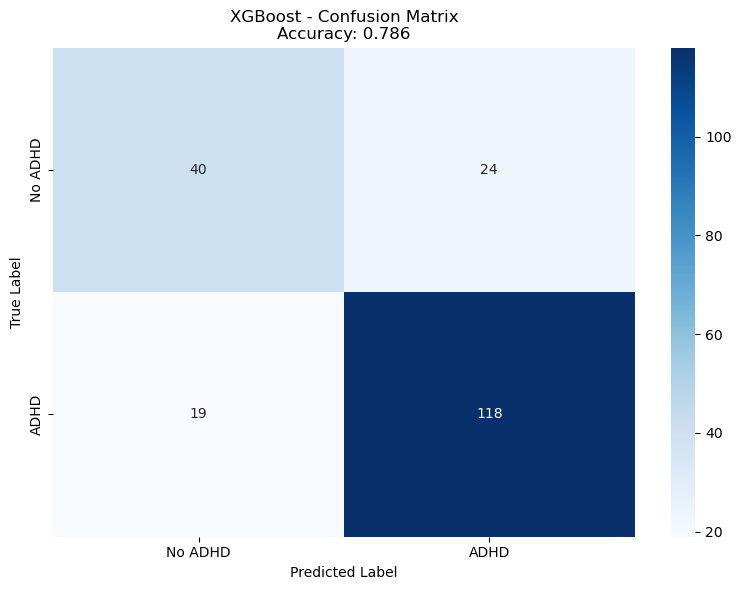

In [6]:
# =============================================================================
# BASELINE MODELS DEFINITION AND TRAINING
# =============================================================================

def define_baseline_models():
    """
    Define baseline machine learning models for comparison.
    
    Returns:
    --------
    dict
        Dictionary of model names and initialized models
    """
   
    
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_STATE, 
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            random_state=RANDOM_STATE, 
            n_estimators=100,
            class_weight='balanced'
        ),
        'SVM': SVC(
            random_state=RANDOM_STATE, 
            probability=True,
            class_weight='balanced'
        ),
        'LightGBM': lgb.LGBMClassifier(
            random_state=RANDOM_STATE,
            n_estimators=100,
            learning_rate=0.1,
            class_weight='balanced',
            verbose=-1  # Suppress training output
        ),
        'XGBoost': xgb.XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=100,
            learning_rate=0.1,
            eval_metric='logloss',
            verbosity=0  # Suppress training output
        )
    }
    
    
    
  
    
    return models

def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Train and evaluate all baseline models.
    
    Parameters:
    -----------
    models : dict
        Dictionary of model names and initialized models
    X_train, X_test : pd.DataFrame
        Training and test feature matrices
    y_train, y_test : pd.Series
        Training and test target vectors
    
    Returns:
    --------
    dict
        Comprehensive results for all models
    """

    
    results = {}
    
    for i, (name, model) in enumerate(models.items(), 1):
       
        
        # Train the model
        model.fit(X_train, y_train)
        
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate comprehensive metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1_binary = f1_score(y_test, y_pred, average='binary')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_binary': f1_binary,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'predictions': y_pred,
            'probabilities': y_proba
        }
        
        # Display results
        print(f" {model}      Performance Metrics:")
        print(f"          Accuracy: {accuracy:.4f}")
        print(f"         Precision: {precision:.4f}")
        print(f"         Recall: {recall:.4f}")
        print(f"         F1-Binary: {f1_binary:.4f}")
        print(f"         F1-Macro: {f1_macro:.4f}")
        print(f"         F1-Weighted: {f1_weighted:.4f}")

    
       
   
        # Confusion matrix
        print(f"\n  Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
       
        
        # Create confusion matrix visualization
        create_confusion_matrix_plot(cm, name, y_test, y_pred)
    
    return results

def create_confusion_matrix_plot(cm, model_name, y_true, y_pred):
    """Create and display confusion matrix plot."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No ADHD', 'ADHD'], 
                yticklabels=['No ADHD', 'ADHD'])
    plt.title(f'{model_name} - Confusion Matrix\nAccuracy: {accuracy_score(y_true, y_pred):.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Define and train models
models = define_baseline_models()
results = train_and_evaluate_models(models, X_train, X_test, y_train, y_test)